# Imports

In [76]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import seaborn as sns
import matplotlib.pyplot as plt


## Load Data

In [77]:
# 1. Load data (train with interactions; test scaled, same interactions)
train = pd.read_csv("datasets/final_datasets/pollution_train_2012_2020_scaled_interactions.csv")
test  = pd.read_csv("datasets/final_datasets/pollution_test_2021_2023_scaled_interactions.csv")

# 2. Load tuned hyperparameters (created earlier)
tuning_df = pd.read_csv("hyperparameter_results/rf_hyperparams_summary.csv")

# 3. Define targets and feature groups (NO confounders here)
pollutant_targets = ["Ozone", "NO2", "PM2.5", "CO"]

core_features = [
    "traffic_daily_total",
    "temperature_2m_max",
    "wind_speed_10m_max_(km/h)",
    "precipitation_sum_(mm)",
    "relative_humidity_2m_max_(%)",
]

extra_features = [
    "daylight_duration_(s)",
    "sunshine_duration_(s)",
    "rain_sum_(mm)",
    "snowfall_sum_(cm)",
    "wind_direction_10m_dominant_(°)",
    "et0_fao_evapotranspiration_(mm)",
    "shortwave_radiation_sum_(mj/m²)",
    "dew_point_2m_max",
    "cloud_cover_max_(%)",
    "cloud_cover_mean_(%)",
    "pressure_msl_max_(hpa)",
    "surface_pressure_max_(hpa)",
    "vapour_pressure_deficit_max_(kpa)",
]
base_features_no_conf = core_features + extra_features

interaction_features = [
    "int_traffic_temp",
    "int_traffic_wind",
    "int_traffic_precip",
    "int_traffic_humidity",
]


## Train Model

In [78]:
from sklearn.metrics import root_mean_squared_error

# 4. Train final RF for each experiment and evaluate on test

final_results = []
trained_models = {}

for _, row in tuning_df.iterrows():
    target = row["target"]
    interaction = row["interaction"]    # "none" or interaction feature name
    print(f'Training with target: {target} and interaction: {interaction}')

    if target not in pollutant_targets:
        continue

    # Choose features
    if interaction == "none":
        feat_list = base_features_no_conf
    else:
        feat_list = base_features_no_conf + [interaction]

    X_train = train[feat_list]
    y_train = train[target]
    X_test  = test[feat_list]
    y_test  = test[target]

    # Rebuild RF with tuned hyperparameters from CSV
    rf = RandomForestRegressor(
        n_estimators=int(row["param_n_estimators"]),
        max_depth=None if pd.isna(row["param_max_depth"]) else int(row["param_max_depth"]),
        min_samples_split=int(row["param_min_samples_split"]),
        min_samples_leaf=int(row["param_min_samples_leaf"]),
        # max_features was not tuned; use sklearn default ("sqrt" for RF regressor)
        random_state=0,
        n_jobs=-1,
    )

    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_test)

    rmse = root_mean_squared_error(y_test, y_pred)
    mae  = mean_absolute_error(y_test, y_pred)
    r2   = r2_score(y_test, y_pred)

    final_results.append({
        "target": target,
        "interaction": interaction,
        "features_used": ",".join(feat_list),
        "test_rmse": rmse,
        "test_mae": mae,
        "test_r2": r2,
    })

    trained_models[(target, interaction)] = {
        "model": rf,
        "X_test": X_test,
        "y_test": y_test,
        "y_pred": y_pred,
        "features": feat_list,
    }

final_results_df = pd.DataFrame(final_results)
final_results_df.to_csv(
    "rf_final_test_metrics_no_confounders.csv",
    index=False,
)
final_results_df


Training with target: Ozone and interaction: none
Training with target: Ozone and interaction: int_traffic_temp
Training with target: Ozone and interaction: int_traffic_wind
Training with target: Ozone and interaction: int_traffic_precip
Training with target: Ozone and interaction: int_traffic_humidity
Training with target: NO2 and interaction: none
Training with target: NO2 and interaction: int_traffic_temp
Training with target: NO2 and interaction: int_traffic_wind
Training with target: NO2 and interaction: int_traffic_precip
Training with target: NO2 and interaction: int_traffic_humidity
Training with target: PM2.5 and interaction: none
Training with target: PM2.5 and interaction: int_traffic_temp
Training with target: PM2.5 and interaction: int_traffic_wind
Training with target: PM2.5 and interaction: int_traffic_precip
Training with target: PM2.5 and interaction: int_traffic_humidity
Training with target: CO and interaction: none
Training with target: CO and interaction: int_traff

,target,interaction,features_used,test_rmse,test_mae,test_r2
0,Ozone,none,"traffic_daily_total,temperature_2m_max,wind_sp...",0.006657,0.005088,0.692449
1,Ozone,int_traffic_temp,"traffic_daily_total,temperature_2m_max,wind_sp...",0.006666,0.005108,0.691689
2,Ozone,int_traffic_wind,"traffic_daily_total,temperature_2m_max,wind_sp...",0.006631,0.005099,0.694865
3,Ozone,int_traffic_precip,"traffic_daily_total,temperature_2m_max,wind_sp...",0.006651,0.005094,0.693063
4,Ozone,int_traffic_humidity,"traffic_daily_total,temperature_2m_max,wind_sp...",0.006697,0.005130,0.688765
5,NO2,none,"traffic_daily_total,temperature_2m_max,wind_sp...",9.580677,7.374891,0.328007
6,NO2,int_traffic_temp,"traffic_daily_total,temperature_2m_max,wind_sp...",9.574638,7.383050,0.328854
7,NO2,int_traffic_wind,"traffic_daily_total,temperature_2m_max,wind_sp...",9.602581,7.413976,0.324931
8,NO2,int_traffic_precip,"traffic_daily_total,temperature_2m_max,wind_sp...",9.583041,7.373404,0.327675
9,NO2,int_traffic_humidity,"traffic_daily_total,temperature_2m_max,wind_sp...",9.579442,7.400251,0.328180


# Plotting

In [79]:
sns.set(style="whitegrid")

def plot_predicted_vs_actual(y_true, y_pred, title=""):
    plt.figure(figsize=(5, 5))
    plt.scatter(y_true, y_pred, alpha=0.3)
    lims = [min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())]
    plt.plot(lims, lims, "r--")
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title(title)
    plt.tight_layout()
    plt.show()

def plot_residuals(y_true, y_pred, title=""):
    residuals = y_true - y_pred
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.scatter(y_pred, residuals, alpha=0.3)
    plt.axhline(0, color="red", linestyle="--")
    plt.xlabel("Predicted")
    plt.ylabel("Residual")
    plt.title(title + " – Residuals vs Predicted")

    plt.subplot(1, 2, 2)
    sns.histplot(residuals, kde=True)
    plt.title(title + " – Residual Distribution")
    plt.tight_layout()
    plt.show()

def plot_feature_importance(model, feature_names, top_n=15, title=""):
    importances = model.feature_importances_
    idx = np.argsort(importances)[::-1][:top_n]
    plt.figure(figsize=(8, 5))
    sns.barplot(
        x=importances[idx],
        y=[feature_names[i] for i in idx],
        orient="h"
    )
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.title(title + " – Top Feature Importances")
    plt.tight_layout()
    plt.show()


# Main

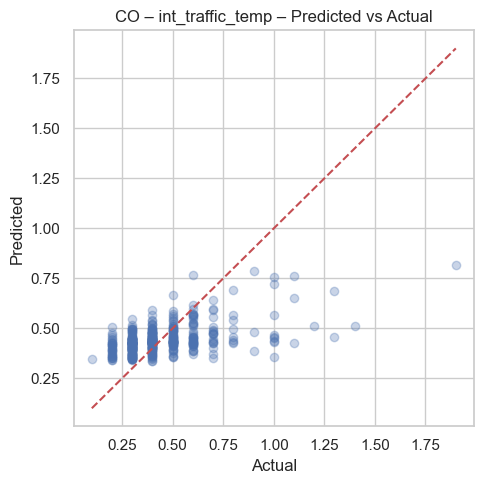

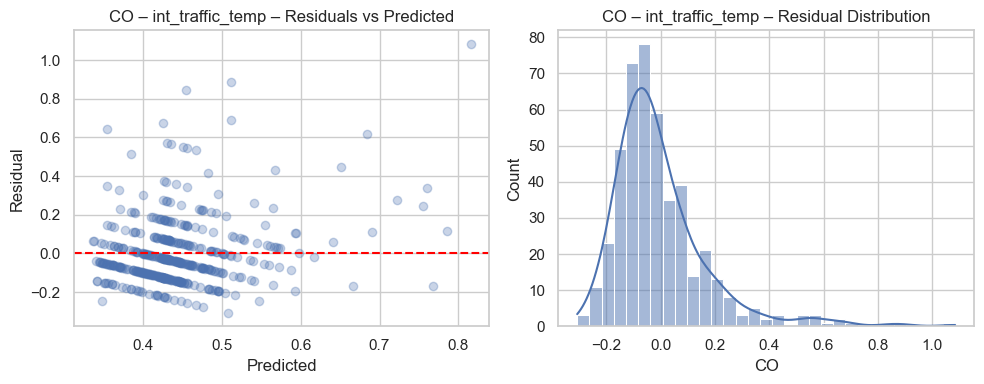

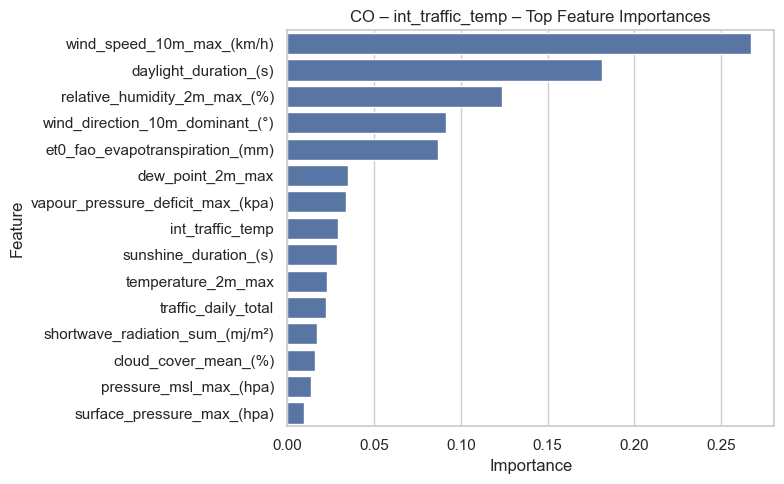

In [80]:
# Example usage for one experiment
target_example = "CO"
interaction_example = "int_traffic_temp"  # or "none", etc.

model_info = trained_models[(target_example, interaction_example)]
model = model_info["model"]
X_test = model_info["X_test"]
y_test = model_info["y_test"]
y_pred = model_info["y_pred"]
feat_list = model_info["features"]

plot_predicted_vs_actual(
    y_test, y_pred,
    title=f"{target_example} – {interaction_example} – Predicted vs Actual"
)

plot_residuals(
    y_test, y_pred,
    title=f"{target_example} – {interaction_example}"
)

plot_feature_importance(
    model, feat_list,
    top_n=15,
    title=f"{target_example} – {interaction_example}"
)


Feature Importances For Each Model

In [81]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

# Create a directory to save the plots
if not os.path.exists("results/Random_Forest/feature_importance_plots"):
    os.makedirs("results/Random_Forest/feature_importance_plots")

# Loop through the trained_models dictionary you created
for (target, interaction), data in trained_models.items():
    model = data["model"]
    features = data["features"]

    # Extract importances
    importances = model.feature_importances_

    # Create a DataFrame
    fi_df = pd.DataFrame({
        "Feature": features,
        "Importance": importances
    }).sort_values(by="Importance", ascending=False)

    # Plotting
    plt.figure(figsize=(10, 6))

    # --- FIXED LINE BELOW ---
    # We added hue="Feature" and legend=False to fix the FutureWarning
    sns.barplot(
        data=fi_df.head(15),
        x="Importance",
        y="Feature",
        hue="Feature",
        palette="viridis",
        legend=False
    )
    # ------------------------

    title = f"Feature Importance: {target} (Interaction: {interaction})"
    plt.title(title)
    plt.xlabel("Importance Score")
    plt.ylabel("Feature")
    plt.tight_layout()

    # Save plot
    filename = f"results/Random_Forest/feature_importance_plots/{target}_{interaction}.png"
    plt.savefig(filename)
    plt.close() # Close figure to free memory

print("Feature importance plots saved to 'feature_importance_plots/' folder.")

Feature importance plots saved to 'feature_importance_plots/' folder.


**Plot Differences in R^2 by Interactions**

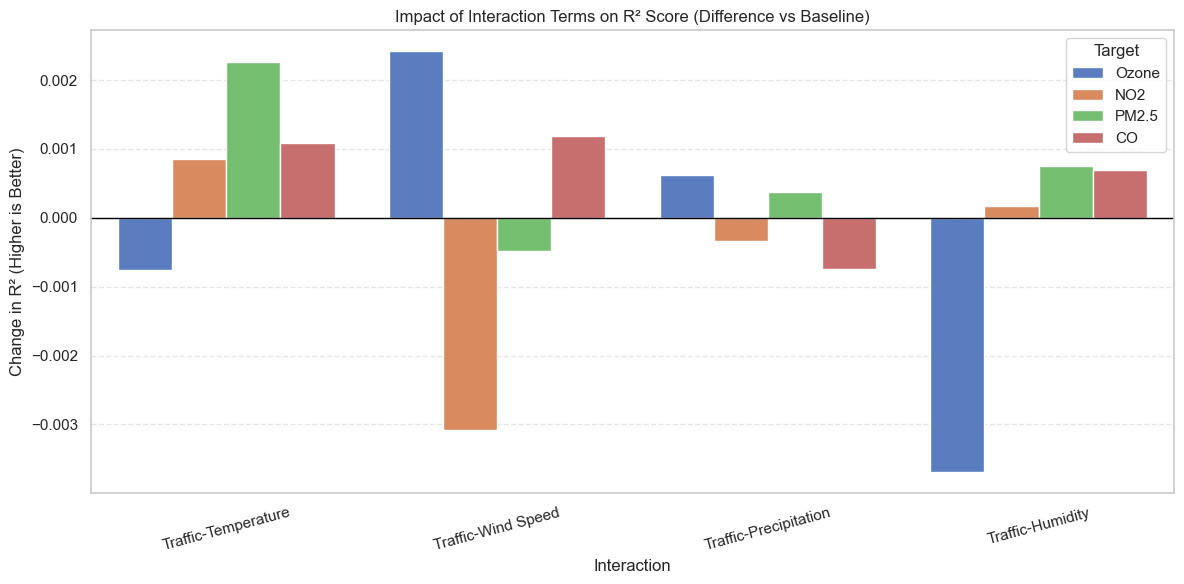

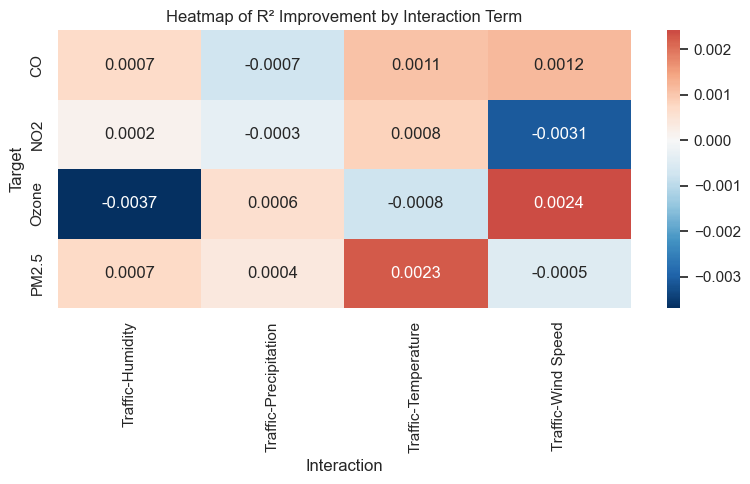

In [82]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load Results
df = pd.read_csv("results/Random_Forest/rf_final_test_metrics_no_confounders.csv")

# 1. Calculate Deltas (Improvement over "none")
results_list = []
targets = df['target'].unique()
interactions = [i for i in df['interaction'].unique() if i != 'none']

for t in targets:
    # Get baseline for this target
    base_row = df[(df['target'] == t) & (df['interaction'] == 'none')]
    if base_row.empty: continue

    base_r2 = base_row['test_r2'].values[0]
    base_rmse = base_row['test_rmse'].values[0]

    for i in interactions:
        row = df[(df['target'] == t) & (df['interaction'] == i)]
        if row.empty: continue

        curr_r2 = row['test_r2'].values[0]
        curr_rmse = row['test_rmse'].values[0]

        results_list.append({
            'Target': t,
            'Interaction': i,
            'Delta_R2': curr_r2 - base_r2,
            'Delta_RMSE': curr_rmse - base_rmse,
            'Pct_Change_RMSE': ((curr_rmse - base_rmse) / base_rmse) * 100
        })

df_deltas = pd.DataFrame(results_list)
label_map = {
    "int_traffic_temp": "Traffic-Temperature",
    "int_traffic_wind": "Traffic-Wind Speed",
    "int_traffic_precip": "Traffic-Precipitation",
    "int_traffic_humidity": "Traffic-Humidity"
}

df_deltas['Interaction'] = df_deltas['Interaction'].replace(label_map)

# 2. Plot R2 Differences
plt.figure(figsize=(12, 6))
sns.barplot(data=df_deltas, x='Interaction', y='Delta_R2', hue='Target', palette='muted')
plt.axhline(0, color='black', linewidth=1)
plt.title("Impact of Interaction Terms on R² Score (Difference vs Baseline)")
plt.ylabel("Change in R² (Higher is Better)")
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# 3. Heatmap of R2 Improvement
pivot_r2 = df_deltas.pivot(index='Target', columns='Interaction', values='Delta_R2')
plt.figure(figsize=(8, 5))
sns.heatmap(pivot_r2, annot=True, cmap='RdBu_r', center=0, fmt=".4f")
plt.title("Heatmap of R² Improvement by Interaction Term")
plt.tight_layout()
plt.show()

**Plot Differences in RMSE by Interactions**


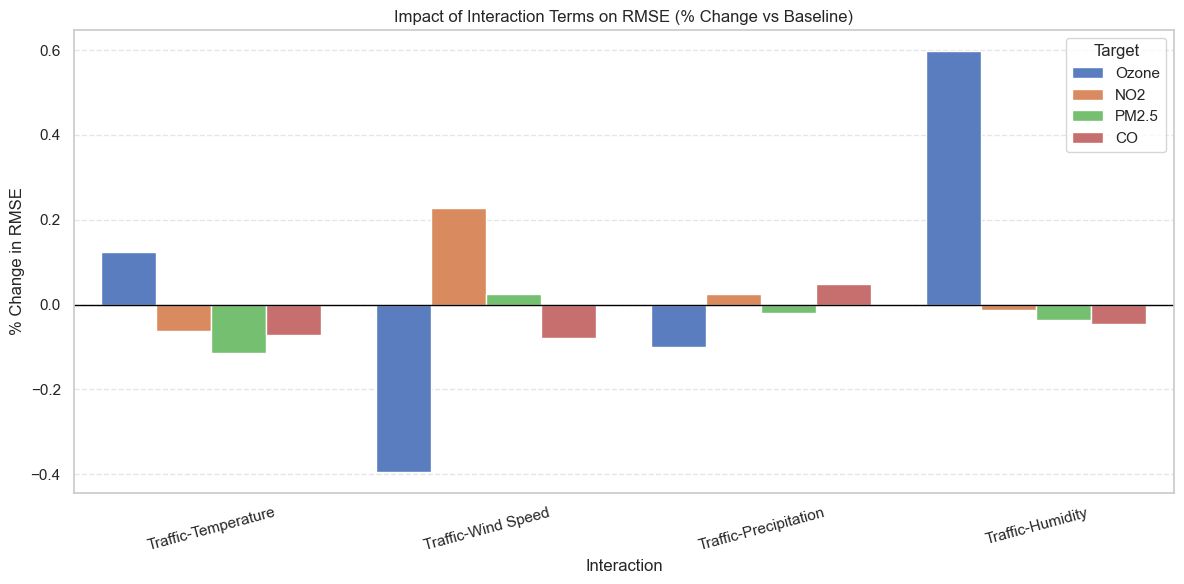

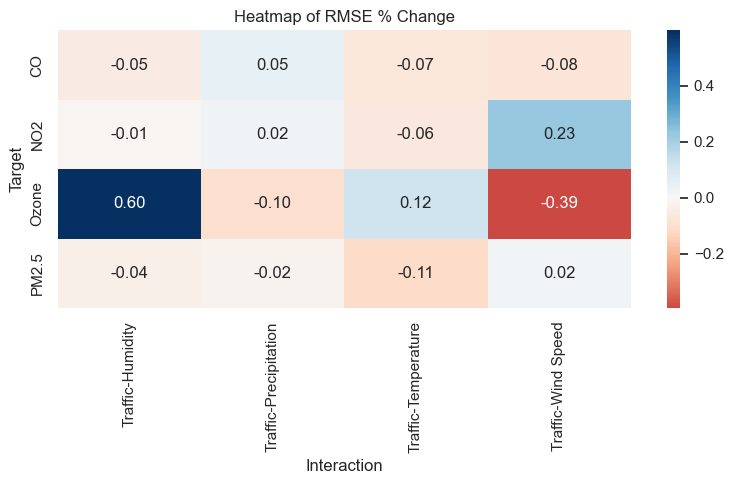

In [83]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load Results
df = pd.read_csv("results/Random_Forest/rf_final_test_metrics_no_confounders.csv")

# 2. Calculate Deltas (Improvement over "none")
results_list = []
targets = df['target'].unique()
interactions = [i for i in df['interaction'].unique() if i != 'none']

for t in targets:
    # Get baseline (no interaction) for this target
    base_row = df[(df['target'] == t) & (df['interaction'] == 'none')]
    if base_row.empty: continue

    base_rmse = base_row['test_rmse'].values[0]

    for i in interactions:
        row = df[(df['target'] == t) & (df['interaction'] == i)]
        if row.empty: continue

        curr_rmse = row['test_rmse'].values[0]

        # Calculate Percentage Change
        # Negative % means RMSE went DOWN (Improvement)
        pct_change = ((curr_rmse - base_rmse) / base_rmse) * 100

        results_list.append({
            'Target': t,
            'Interaction': i,
            'Pct_Change_RMSE': pct_change
        })

df_deltas = pd.DataFrame(results_list)

# --- NEW STEP: Rename Labels ---
label_map = {
    "int_traffic_temp": "Traffic-Temperature",
    "int_traffic_wind": "Traffic-Wind Speed",
    "int_traffic_precip": "Traffic-Precipitation",
    "int_traffic_humidity": "Traffic-Humidity"
}

df_deltas['Interaction'] = df_deltas['Interaction'].replace(label_map)

# 3. Plot RMSE Differences (Bar Chart)
plt.figure(figsize=(12, 6))
sns.barplot(data=df_deltas, x='Interaction', y='Pct_Change_RMSE', hue='Target', palette='muted')
plt.axhline(0, color='black', linewidth=1)
plt.title("Impact of Interaction Terms on RMSE (% Change vs Baseline)")
plt.ylabel("% Change in RMSE")
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# 4. Heatmap of RMSE Improvement
# We use 'RdBu' (Red-Blue) colormap.
# Blue (Negative values) = Good (Error decreased)
# Red (Positive values) = Bad (Error increased)
pivot_rmse = df_deltas.pivot(index='Target', columns='Interaction', values='Pct_Change_RMSE')
plt.figure(figsize=(8, 5))
sns.heatmap(pivot_rmse, annot=True, cmap='RdBu', center=0, fmt=".2f")
plt.title("Heatmap of RMSE % Change")
plt.tight_layout()
plt.show()

## Run the model with confounders

In [84]:
from sklearn.metrics import root_mean_squared_error

# 4. Train final RF for each experiment and evaluate on test

final_results = []
trained_models = {}
confounder_features = ["season_spring", "season_summer", "season_fall", "is_weekend", "is_covid"]
base_features_with_conf = base_features_no_conf + confounder_features

for _, row in tuning_df.iterrows():
    target = row["target"]
    interaction = row["interaction"]    # "none" or interaction feature name
    print(f'Training with target: {target} and interaction: {interaction}')

    if target not in pollutant_targets:
        continue

    # Choose features
    if interaction == "none":
        feat_list = base_features_with_conf
    else:
        feat_list = base_features_with_conf + [interaction]

    X_train = train[feat_list]
    y_train = train[target]
    X_test  = test[feat_list]
    y_test  = test[target]

    # Rebuild RF with tuned hyperparameters from CSV
    rf = RandomForestRegressor(
        n_estimators=int(row["param_n_estimators"]),
        max_depth=None if pd.isna(row["param_max_depth"]) else int(row["param_max_depth"]),
        min_samples_split=int(row["param_min_samples_split"]),
        min_samples_leaf=int(row["param_min_samples_leaf"]),
        # max_features was not tuned; use sklearn default ("sqrt" for RF regressor)
        random_state=0,
        n_jobs=-1,
    )

    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_test)

    rmse = root_mean_squared_error(y_test, y_pred)
    mae  = mean_absolute_error(y_test, y_pred)
    r2   = r2_score(y_test, y_pred)

    final_results.append({
        "target": target,
        "interaction": interaction,
        "features_used": ",".join(feat_list),
        "test_rmse": rmse,
        "test_mae": mae,
        "test_r2": r2,
    })

    trained_models[(target, interaction)] = {
        "model": rf,
        "X_test": X_test,
        "y_test": y_test,
        "y_pred": y_pred,
        "features": feat_list,
    }

final_results_df = pd.DataFrame(final_results)
final_results_df.to_csv(
    "rf_final_test_metrics_with_confounders.csv",
    index=False,
)



Training with target: Ozone and interaction: none
Training with target: Ozone and interaction: int_traffic_temp
Training with target: Ozone and interaction: int_traffic_wind
Training with target: Ozone and interaction: int_traffic_precip
Training with target: Ozone and interaction: int_traffic_humidity
Training with target: NO2 and interaction: none
Training with target: NO2 and interaction: int_traffic_temp
Training with target: NO2 and interaction: int_traffic_wind
Training with target: NO2 and interaction: int_traffic_precip
Training with target: NO2 and interaction: int_traffic_humidity
Training with target: PM2.5 and interaction: none
Training with target: PM2.5 and interaction: int_traffic_temp
Training with target: PM2.5 and interaction: int_traffic_wind
Training with target: PM2.5 and interaction: int_traffic_precip
Training with target: PM2.5 and interaction: int_traffic_humidity
Training with target: CO and interaction: none
Training with target: CO and interaction: int_traff

**Visualizations**

In [85]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

# Create a directory to save the plots
if not os.path.exists("results/Random_Forest/feature_importance_plots"):
    os.makedirs("results/Random_Forest/feature_importance_plots")

# Loop through the trained_models dictionary you created
for (target, interaction), data in trained_models.items():
    model = data["model"]
    features = data["features"]

    # Extract importances
    importances = model.feature_importances_

    # Create a DataFrame
    fi_df = pd.DataFrame({
        "Feature": features,
        "Importance": importances
    }).sort_values(by="Importance", ascending=False)

    # Plotting
    plt.figure(figsize=(10, 6))

    # --- FIXED LINE BELOW ---
    # We added hue="Feature" and legend=False to fix the FutureWarning
    sns.barplot(
        data=fi_df.head(15),
        x="Importance",
        y="Feature",
        hue="Feature",
        palette="viridis",
        legend=False
    )
    # ------------------------

    title = f"Feature Importance: {target} (Interaction: {interaction})"
    plt.title(title)
    plt.xlabel("Importance Score")
    plt.ylabel("Feature")
    plt.tight_layout()

    # Save plot
    filename = f"results/Random_Forest/feature_importance_plots/With_Confounders/{target}_{interaction}.png"
    plt.savefig(filename)
    plt.close() # Close figure to free memory

print("Feature importance plots saved to 'feature_importance_plots/' folder.")

Feature importance plots saved to 'feature_importance_plots/' folder.


**Plot Differences in R2**

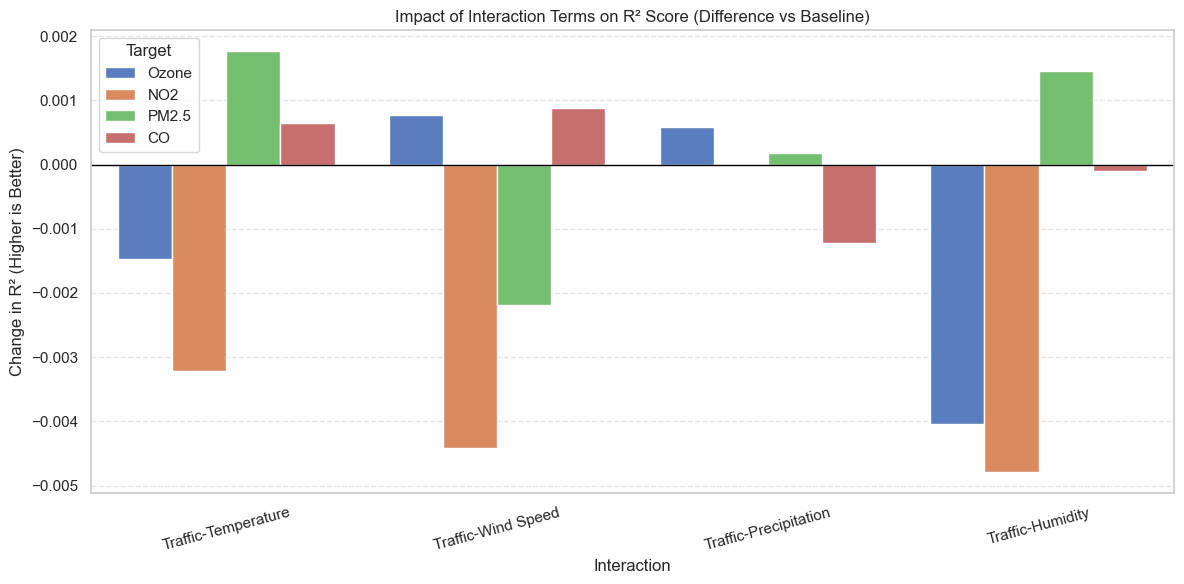

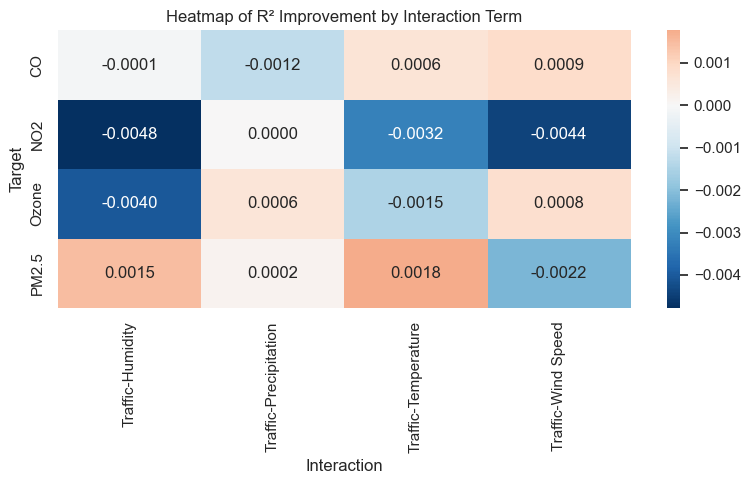

In [86]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load Results
df = pd.read_csv("results/Random_Forest/rf_final_test_metrics_with_confounders.csv")

# 1. Calculate Deltas (Improvement over "none")
results_list = []
targets = df['target'].unique()
interactions = [i for i in df['interaction'].unique() if i != 'none']

for t in targets:
    # Get baseline for this target
    base_row = df[(df['target'] == t) & (df['interaction'] == 'none')]
    if base_row.empty: continue

    base_r2 = base_row['test_r2'].values[0]
    base_rmse = base_row['test_rmse'].values[0]

    for i in interactions:
        row = df[(df['target'] == t) & (df['interaction'] == i)]
        if row.empty: continue

        curr_r2 = row['test_r2'].values[0]
        curr_rmse = row['test_rmse'].values[0]

        results_list.append({
            'Target': t,
            'Interaction': i,
            'Delta_R2': curr_r2 - base_r2,
            'Delta_RMSE': curr_rmse - base_rmse,
            'Pct_Change_RMSE': ((curr_rmse - base_rmse) / base_rmse) * 100
        })

df_deltas = pd.DataFrame(results_list)
label_map = {
    "int_traffic_temp": "Traffic-Temperature",
    "int_traffic_wind": "Traffic-Wind Speed",
    "int_traffic_precip": "Traffic-Precipitation",
    "int_traffic_humidity": "Traffic-Humidity"
}

df_deltas['Interaction'] = df_deltas['Interaction'].replace(label_map)

# 2. Plot R2 Differences
plt.figure(figsize=(12, 6))
sns.barplot(data=df_deltas, x='Interaction', y='Delta_R2', hue='Target', palette='muted')
plt.axhline(0, color='black', linewidth=1)
plt.title("Impact of Interaction Terms on R² Score (Difference vs Baseline)")
plt.ylabel("Change in R² (Higher is Better)")
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# 3. Heatmap of R2 Improvement
pivot_r2 = df_deltas.pivot(index='Target', columns='Interaction', values='Delta_R2')
plt.figure(figsize=(8, 5))
sns.heatmap(pivot_r2, annot=True, cmap='RdBu_r', center=0, fmt=".4f")
plt.title("Heatmap of R² Improvement by Interaction Term")
plt.tight_layout()
plt.show()

__**Plot Differences in RMSE__**

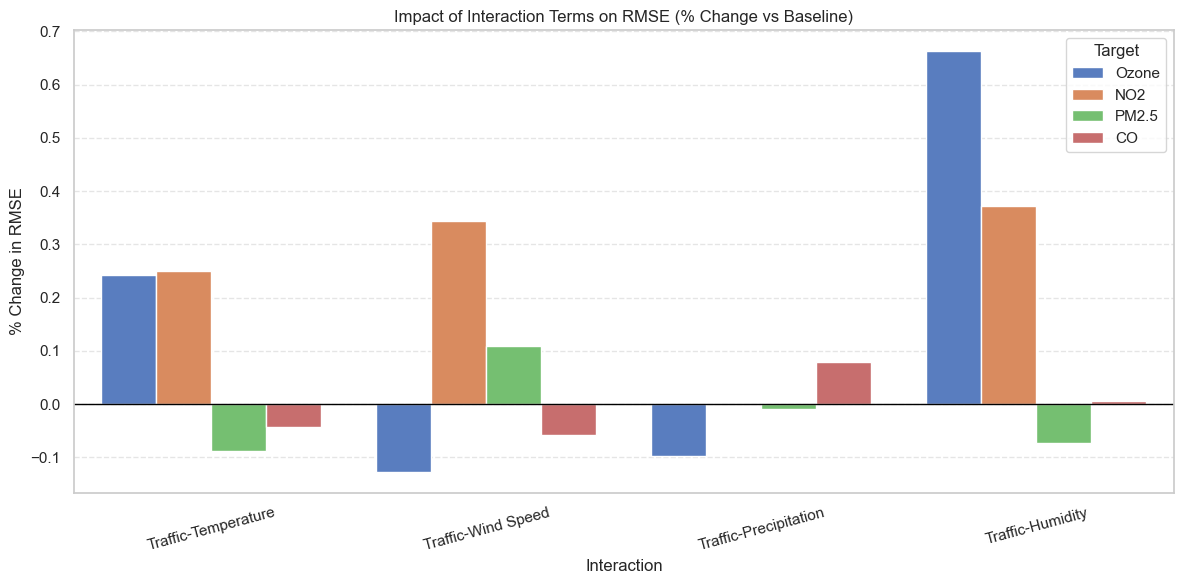

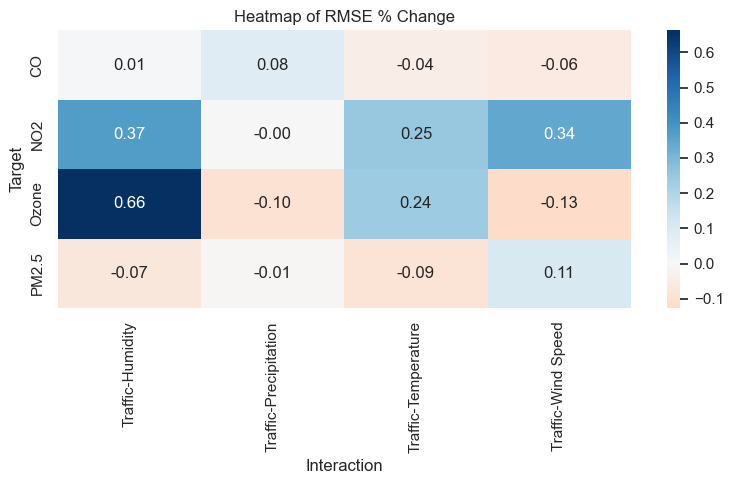

In [87]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load Results
df = pd.read_csv("results/Random_Forest/rf_final_test_metrics_with_confounders.csv")

# 2. Calculate Deltas (Improvement over "none")
results_list = []
targets = df['target'].unique()
interactions = [i for i in df['interaction'].unique() if i != 'none']

for t in targets:
    # Get baseline (no interaction) for this target
    base_row = df[(df['target'] == t) & (df['interaction'] == 'none')]
    if base_row.empty: continue

    base_rmse = base_row['test_rmse'].values[0]

    for i in interactions:
        row = df[(df['target'] == t) & (df['interaction'] == i)]
        if row.empty: continue

        curr_rmse = row['test_rmse'].values[0]

        # Calculate Percentage Change
        # Negative % means RMSE went DOWN (Improvement)
        pct_change = ((curr_rmse - base_rmse) / base_rmse) * 100

        results_list.append({
            'Target': t,
            'Interaction': i,
            'Pct_Change_RMSE': pct_change
        })

df_deltas = pd.DataFrame(results_list)

# --- NEW STEP: Rename Labels ---
label_map = {
    "int_traffic_temp": "Traffic-Temperature",
    "int_traffic_wind": "Traffic-Wind Speed",
    "int_traffic_precip": "Traffic-Precipitation",
    "int_traffic_humidity": "Traffic-Humidity"
}

df_deltas['Interaction'] = df_deltas['Interaction'].replace(label_map)

# 3. Plot RMSE Differences (Bar Chart)
plt.figure(figsize=(12, 6))
sns.barplot(data=df_deltas, x='Interaction', y='Pct_Change_RMSE', hue='Target', palette='muted')
plt.axhline(0, color='black', linewidth=1)
plt.title("Impact of Interaction Terms on RMSE (% Change vs Baseline)")
plt.ylabel("% Change in RMSE")
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# 4. Heatmap of RMSE Improvement
# We use 'RdBu' (Red-Blue) colormap.
# Blue (Negative values) = Good (Error decreased)
# Red (Positive values) = Bad (Error increased)
pivot_rmse = df_deltas.pivot(index='Target', columns='Interaction', values='Pct_Change_RMSE')
plt.figure(figsize=(8, 5))
sns.heatmap(pivot_rmse, annot=True, cmap='RdBu', center=0, fmt=".2f")
plt.title("Heatmap of RMSE % Change")
plt.tight_layout()
plt.show()

## Comparison With and Without Confounders Control

In [88]:
import pandas as pd

# Load results
no_conf = pd.read_csv('results/Random_Forest/rf_final_test_metrics_no_confounders.csv')
with_conf = pd.read_csv('results/Random_Forest/rf_final_test_metrics_with_confounders.csv')

# Add suffixes so columns stay distinct after merge
cmp_df = no_conf.merge(
    with_conf,
    on=["target", "interaction"],
    suffixes=("_no_conf", "_with_conf")
)

# Compute deltas (with confounders minus without)
cmp_df["delta_rmse_conf"] = cmp_df["test_rmse_with_conf"] - cmp_df["test_rmse_no_conf"]
cmp_df["delta_r2_conf"]   = cmp_df["test_r2_with_conf"]   - cmp_df["test_r2_no_conf"]
cmp_df["delta_mae_conf"]  = cmp_df["test_mae_with_conf"]  - cmp_df["test_mae_no_conf"]

# Negative delta_rmse_conf => adding confounders improved RMSE
cmp_df[[
    "target", "interaction",
    "test_rmse_no_conf", "test_rmse_with_conf", "delta_rmse_conf",
    "test_r2_no_conf",   "test_r2_with_conf",   "delta_r2_conf"
]]
# 1) Effect of interactions without confounders
no_conf["has_interaction"] = no_conf["interaction"] != "none"
agg_no = (
    no_conf.groupby(["target", "has_interaction"], as_index=False)
           .agg(best_rmse=("test_rmse", "min"))
)

# 2) Effect of interactions with confounders
with_conf["has_interaction"] = with_conf["interaction"] != "none"
agg_with = (
    with_conf.groupby(["target", "has_interaction"], as_index=False)
             .agg(best_rmse=("test_rmse", "min"))
)

# Pivot so you can read off improvement for each setting
pivot_no   = agg_no.pivot(index="target", columns="has_interaction", values="best_rmse")
pivot_with = agg_with.pivot(index="target", columns="has_interaction", values="best_rmse")
pivot_no.columns   = ["rmse_no_int_no_conf",   "rmse_with_int_no_conf"]
pivot_with.columns = ["rmse_no_int_with_conf", "rmse_with_int_with_conf"]

comparison = pivot_no.join(pivot_with)
comparison["delta_int_no_conf"]   = comparison["rmse_with_int_no_conf"]   - comparison["rmse_no_int_no_conf"]
comparison["delta_int_with_conf"] = comparison["rmse_with_int_with_conf"] - comparison["rmse_no_int_with_conf"]
print(comparison)


        rmse_no_int_no_conf  rmse_with_int_no_conf  rmse_no_int_with_conf  \
target                                                                      
CO                 0.175769               0.175631               0.176398   
NO2                9.580677               9.574638               9.364212   
Ozone              0.006657               0.006631               0.006614   
PM2.5             12.942050              12.927420              12.911681   

        rmse_with_int_with_conf  delta_int_no_conf  delta_int_with_conf  
target                                                                   
CO                     0.176297          -0.000138            -0.000101  
NO2                    9.364180          -0.006039            -0.000033  
Ozone                  0.006606          -0.000026            -0.000008  
PM2.5                 12.900246          -0.014630            -0.011435  


In [89]:
# 1) Effect of interactions on R² without confounders
agg_no_r2 = (
    no_conf.groupby(["target", "has_interaction"], as_index=False)
           .agg(best_r2=("test_r2", "max"))
)

# 2) Effect of interactions on R² with confounders
agg_with_r2 = (
    with_conf.groupby(["target", "has_interaction"], as_index=False)
             .agg(best_r2=("test_r2", "max"))
)

pivot_no_r2 = agg_no_r2.pivot(index="target", columns="has_interaction", values="best_r2")
pivot_with_r2 = agg_with_r2.pivot(index="target", columns="has_interaction", values="best_r2")

pivot_no_r2.columns   = ["r2_no_int_no_conf",   "r2_with_int_no_conf"]
pivot_with_r2.columns = ["r2_no_int_with_conf", "r2_with_int_with_conf"]

comparison_r2 = pivot_no_r2.join(pivot_with_r2)
comparison_r2["delta_int_no_conf"]   = comparison_r2["r2_with_int_no_conf"]   - comparison_r2["r2_no_int_no_conf"]
comparison_r2["delta_int_with_conf"] = comparison_r2["r2_with_int_with_conf"] - comparison_r2["r2_no_int_with_conf"]


**RMSE Comparison**

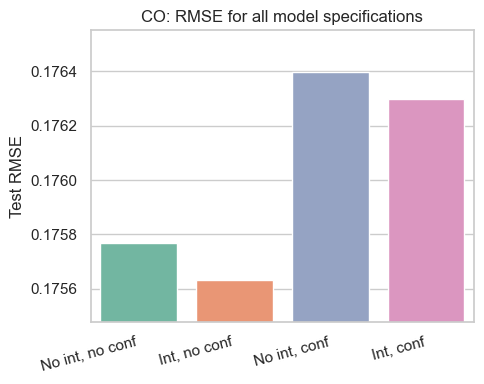

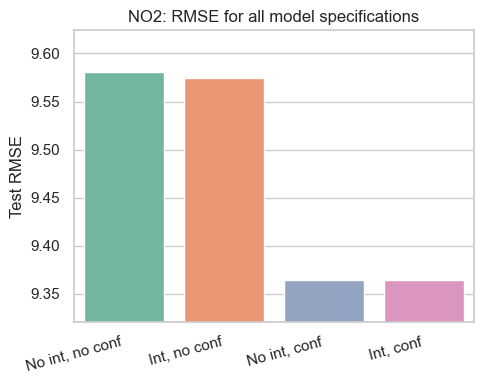

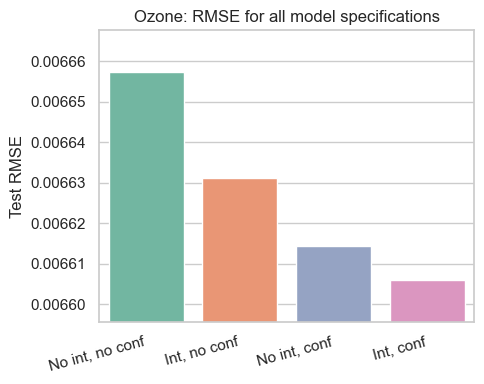

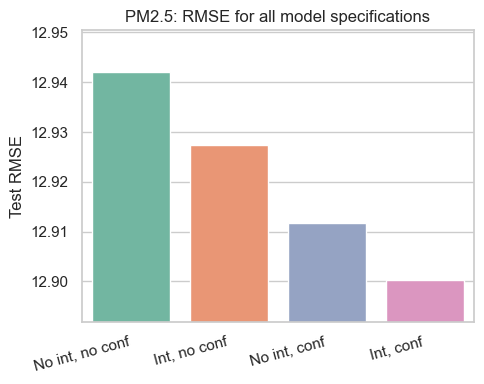

In [90]:
import seaborn as sns
sns.set(style="whitegrid")

# For each target: interactions effect with vs without confounders

targets = comparison.index.tolist()

for t in targets:
    row = comparison.loc[t]

    rmse_values = [
        row["rmse_no_int_no_conf"],
        row["rmse_with_int_no_conf"],
        row["rmse_no_int_with_conf"],
        row["rmse_with_int_with_conf"],
    ]
    labels = [
        "No int, no conf",
        "Int, no conf",
        "No int, conf",
        "Int, conf",
    ]

    plot_df = pd.DataFrame({"label": labels, "rmse": rmse_values})

    plt.figure(figsize=(5, 4))
    ax = sns.barplot(
        data=plot_df,
        x="label",
        y="rmse",
        hue="label",      # use x also as hue
        palette="Set2",
        legend=False      # avoid duplicate legend
    )
    ymin = min(rmse_values)
    ymax = max(rmse_values)
    margin = (ymax - ymin) * 0.2  # 20% padding
    if margin == 0:               # all values identical
        margin = ymax * 0.05
    ax.set_ylim(ymin - margin, ymax + margin)

    ax.set_ylabel("Test RMSE")
    ax.set_xlabel("")
    ax.set_title(f"{t}: RMSE for all model specifications")
    plt.xticks(rotation=15, ha="right")
    plt.tight_layout()
    plt.show()




**R2 Comparison**

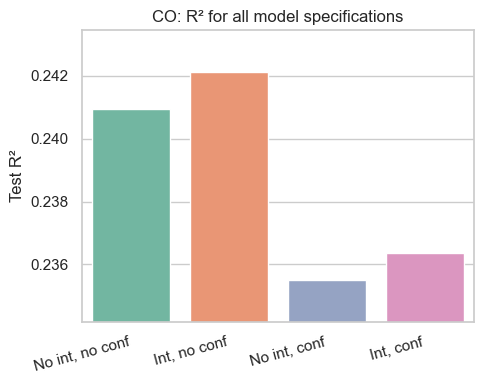

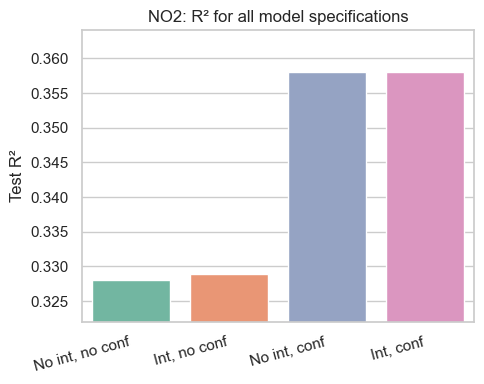

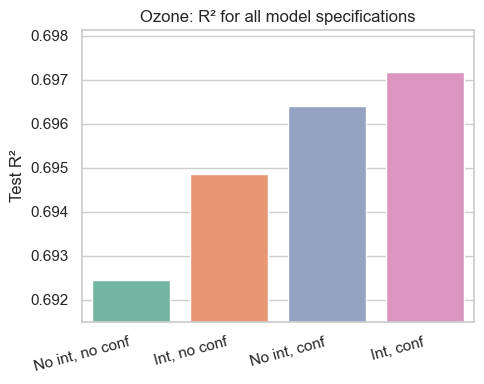

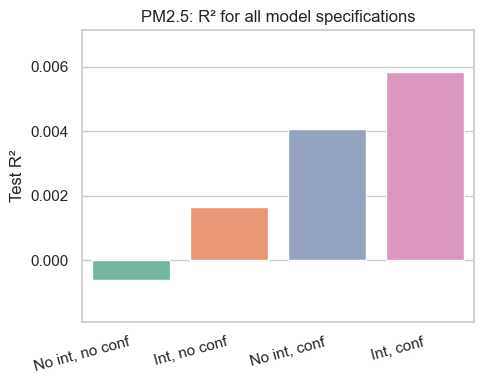

In [91]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

targets = comparison_r2.index.tolist()

for t in targets:
    row = comparison_r2.loc[t]

    r2_values = [
        row["r2_no_int_no_conf"],
        row["r2_with_int_no_conf"],
        row["r2_no_int_with_conf"],
        row["r2_with_int_with_conf"],
    ]
    labels = [
        "No int, no conf",
        "Int, no conf",
        "No int, conf",
        "Int, conf",
    ]

    plot_df = pd.DataFrame({"label": labels, "r2": r2_values})

    plt.figure(figsize=(5, 4))
    ax = sns.barplot(
        data=plot_df,
        x="label",
        y="r2",
        hue="label",
        palette="Set2",
        legend=False,
    )

    # Zoom y-axis around this target's R² values
    ymin = min(r2_values)
    ymax = max(r2_values)
    margin = (ymax - ymin) * 0.2
    if margin == 0:
        margin = 0.05
    ax.set_ylim(ymin - margin, ymax + margin)

    ax.set_ylabel("Test R²")
    ax.set_xlabel("")
    ax.set_title(f"{t}: R² for all model specifications")
    plt.xticks(rotation=15, ha="right")
    plt.tight_layout()
    plt.show()
